In [1]:
# %cd D:\\graduation\\YuEbaoPrediction\\ARIMA_prediction
%cd /Users/utopia/Local File/Code/MyGit/YuEbaoPrediction/ARIMA_prediction

/Users/utopia/Local File/Code/MyGit/YuEbaoPrediction/ARIMA_prediction


/usr/local/anaconda3/envs/conda36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/usr/local/anaconda3/envs/conda36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


tBalance
yBalance
total_purchase_amt
direct_purchase_amt
purchase_bal_amt
purchase_bank_amt
total_redeem_amt
consume_amt
transfer_amt
tftobal_amt
tftocard_amt
share_amt


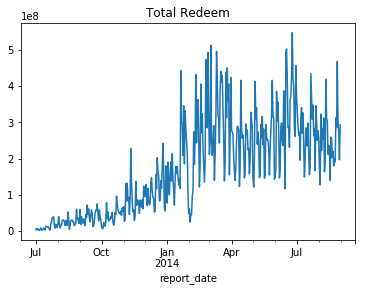

[292943033.0]


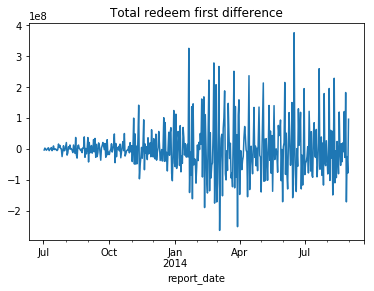

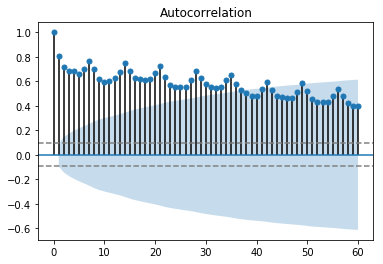

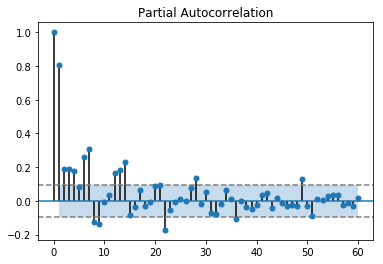

[292943033.0]
一阶差分数据ADF


/usr/local/anaconda3/envs/conda36/lib/python3.6/site-packages/ipykernel_launcher.py:55: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).mean()
/usr/local/anaconda3/envs/conda36/lib/python3.6/site-packages/ipykernel_launcher.py:56: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).std()


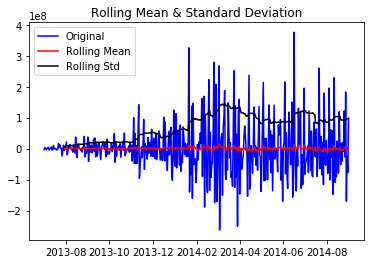

Results of Dickey-Fuller Test:
Test Statistic                -1.169199e+01
p-value                        1.644372e-21
#Lags Used                     1.200000e+01
Number of Observations Used    4.130000e+02
Critical Value (1%)           -3.446283e+00
Critical Value (5%)           -2.868564e+00
Critical Value (10%)          -2.570511e+00
dtype: float64


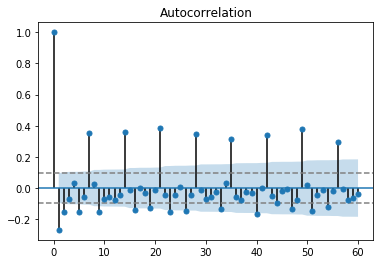

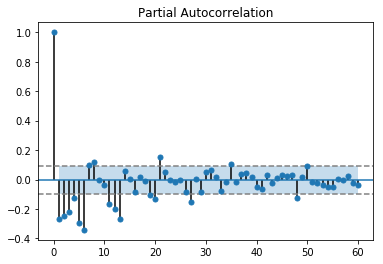

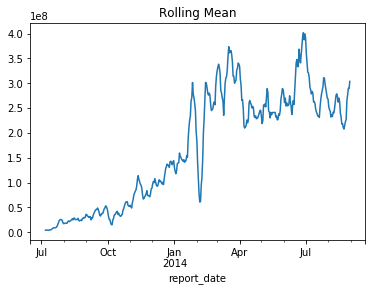

[303860504.14285713]


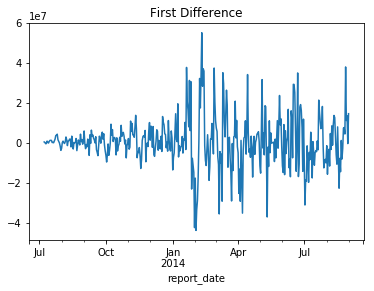

移动平均并差分后ADF


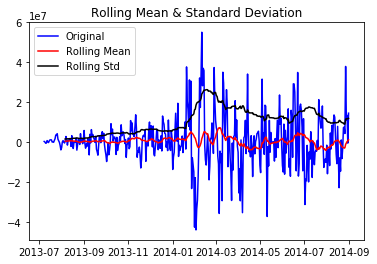

Results of Dickey-Fuller Test:
Test Statistic                -6.240988e+00
p-value                        4.697925e-08
#Lags Used                     1.400000e+01
Number of Observations Used    4.050000e+02
Critical Value (1%)           -3.446600e+00
Critical Value (5%)           -2.868703e+00
Critical Value (10%)          -2.570586e+00
dtype: float64


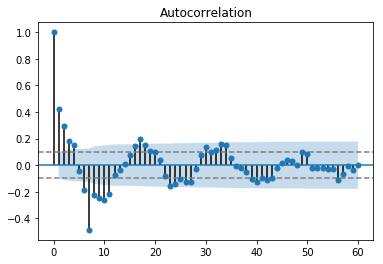

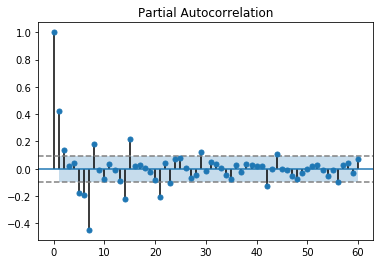

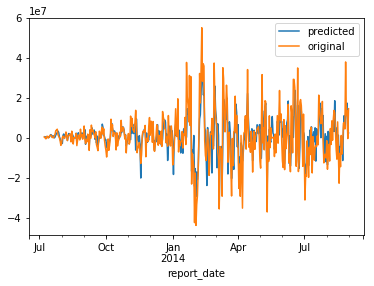

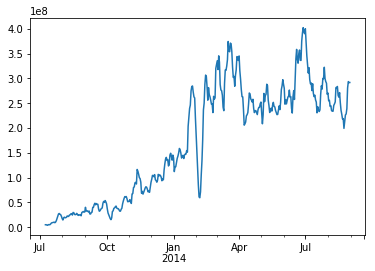

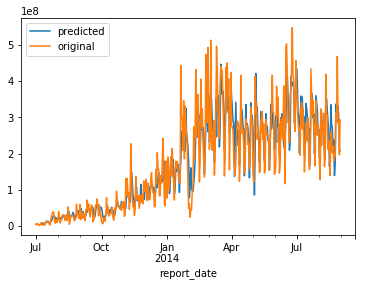

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import sys
from statsmodels.tsa.arima_model import ARMA

def err(true,predicted):
    err = 0
    for i in range(len(true)):
        tmp = (true[i]-predicted[i])/true[i]
        err += tmp*tmp
    standard_err = np.sqrt(err/len(true))
    return standard_err
# 差分操作,d代表差分序列，比如[1,1,1]可以代表3阶差分。  [12,1]可以代表第一次差分偏移量是12，第二次差分偏移量是1
def diff_ts(ts, d):
    global shift_ts_list
    #  动态预测第二日的值时所需要的差分序列
    global last_data_shift_list #这个序列在恢复过程中需要用到
    shift_ts_list = []
    last_data_shift_list = []
    tmp_ts = ts
    for i in d:
        last_data_shift_list.append(tmp_ts[-i])
        print (last_data_shift_list)
        shift_ts = tmp_ts.shift(i)
        shift_ts_list.append(shift_ts)
        tmp_ts = tmp_ts - shift_ts
    tmp_ts.dropna(inplace=True)
    return tmp_ts

def predict_diff_recover(predict_value, d):
    if isinstance(predict_value, float):
        tmp_data = predict_value
        for i in range(len(d)):
            tmp_data = tmp_data + last_data_shift_list[-i-1]
    elif isinstance(predict_value, np.ndarray):
        tmp_data = predict_value[0]
        for i in range(len(d)):
            tmp_data = tmp_data + last_data_shift_list[-i-1]
    else:
        tmp_data = predict_value
        for i in range(len(d)):
            try:
                tmp_data = tmp_data.add(shift_ts_list[-i-1])
            except:
                raise ValueError('What you input is not pd.Series type!')
        tmp_data.dropna(inplace=True)
    return tmp_data

def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=30)
    rolstd = pd.rolling_std(timeseries, window=30)

    # Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


def proper_model(ts_log_diff, maxLag):
    best_p = 0
    best_q = 0
    best_bic = sys.maxsize
    best_model=None
    for p in np.arange(maxLag):
        for q in np.arange(maxLag):
            model = ARMA(ts_log_diff, order=(p, q))
            try:
                results_ARMA = model.fit(disp=-1)
            except:
                continue
            bic = results_ARMA.bic
            print (bic, best_bic)
            if bic < best_bic:
                best_p = p
                best_q = q
                best_bic = bic
                best_model = results_ARMA
    print(best_p,best_q,best_model)

df = pd.read_csv('../file/user_balance_table_all.csv', index_col='user_id', names=['user_id', 'report_date', 'tBalance', 'yBalance', 'total_purchase_amt', 'direct_purchase_amt', 'purchase_bal_amt', 'purchase_bank_amt', 'total_redeem_amt', 'consume_amt', 'transfer_amt', 'tftobal_amt', 'tftocard_amt', 'share_amt', 'category1', 'category2', 'category3', 'category4'
], parse_dates=[1])

df['report_date'] = pd.to_datetime(df['report_date'], errors='coerce')

labels = ['tBalance', 'yBalance', 'total_purchase_amt', 'direct_purchase_amt', 'purchase_bal_amt', 'purchase_bank_amt', 'total_redeem_amt', 'consume_amt', 'transfer_amt', 'tftobal_amt', 'tftocard_amt', 'share_amt']
for label in labels:
    print(label)
    df[label] = pd.to_numeric(df[label], errors='coerce')

df = df.groupby('report_date').sum()
total_redeem_original = df['total_redeem_amt']
# ts = ts['2014-04-01':'2014-06-30']
total_redeem_original



# print('原数据ADF')
# test_stationarity(ts)

total_redeem_original.plot()
plt.title('Total Redeem')
plt.show()

#一阶差分
diff_1 = diff_ts(total_redeem_original, [1])
diff_1.plot()
# plt.title('Total purchase first difference')
plt.title('Total redeem first difference')

plt.show()


plt.figure()
plt.axhline(y=-1.96/np.sqrt(len(total_redeem_original)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(total_redeem_original)), linestyle='--', color='gray')
plot_acf(total_redeem_original, ax=plt.gca(), lags=60)
plt.show()

plt.axhline(y=-1.96/np.sqrt(len(total_redeem_original)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(total_redeem_original)), linestyle='--', color='gray')
plot_pacf(total_redeem_original, ax=plt.gca(), lags=60)
plt.show()

diff_1 = diff_ts(total_redeem_original, [1])

print('一阶差分数据ADF')
test_stationarity(diff_1)

plt.figure()
plt.axhline(y=-1.96/np.sqrt(len(diff_1)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff_1)),linestyle='--',color='gray')
plot_acf(diff_1, ax=plt.gca(), lags=60)
plt.show()

plt.axhline(y=-1.96/np.sqrt(len(diff_1)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff_1)),linestyle='--',color='gray')
plot_pacf(diff_1, ax=plt.gca(), lags=60)
plt.show()

rol_mean = total_redeem_original.rolling(window=7).mean()
rol_mean.dropna(inplace=True)

rol_mean.plot()
plt.title('Rolling Mean')
plt.show()

ts_diff_1 = diff_ts(rol_mean, [1])

ts_diff_1.plot()
plt.title('First Difference')
plt.show()

print('移动平均并差分后ADF')
test_stationarity(ts_diff_1)

plt.figure()
plt.axhline(y=-1.96/np.sqrt(len(ts_diff_1)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff_1)),linestyle='--',color='gray')
plot_acf(ts_diff_1, ax=plt.gca(), lags=60)
plt.show()

plt.axhline(y=-1.96/np.sqrt(len(ts_diff_1)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff_1)),linestyle='--',color='gray')
plot_pacf(ts_diff_1, ax=plt.gca(), lags=60)
plt.show()

# proper_model(ts_diff_1, 10)

model = ARMA(ts_diff_1, order=(1, 8))
result_arma = model.fit(disp=-1, method='css')

predict_ts = result_arma.predict()

predict_ts.plot(label='predicted')
ts_diff_1.plot(label='original')
plt.legend(loc='best')
plt.show()

recovery_diff_1 = predict_diff_recover(predict_ts, [1])
recovery_diff_1.plot()
plt.show()

rol_sum = total_redeem_original.rolling(window=6).sum()
total_redeem_prediction = recovery_diff_1 * 7 - rol_sum.shift(1)

total_redeem_prediction.plot(label='predicted')
total_redeem_original.plot(label='original')

plt.legend(loc='best')
plt.show()


In [ ]:

df = df[8:]
df['total_redeem_amt'] = total_redeem_residual_values
df.to_csv('../file/hybrid_total_redeem.csv')
# print(total_redeem_residual_values)


array([[ 0.01801768],
       [ 0.02215224],
       [ 0.0363741 ],
       [ 0.0258545 ],
       [ 0.00562886],
       [ 0.01355051],
       [ 0.04067867],
       [ 0.04332599],
       [ 0.02034658],
       [ 0.01525825],
       [ 0.02529775],
       [ 0.0112185 ],
       [ 0.01196664],
       [ 0.03249659],
       [ 0.05129684],
       [ 0.04096348],
       [ 0.05054262],
       [ 0.03702505],
       [ 0.00775394],
       [ 0.02802087],
       [ 0.04637075],
       [ 0.0399537 ],
       [ 0.04747845],
       [ 0.04619858],
       [ 0.02991917],
       [ 0.01240763],
       [ 0.03808526],
       [ 0.03584159],
       [ 0.04352789],
       [ 0.03611996],
       [ 0.03673893],
       [ 0.02496932],
       [ 0.0113477 ],
       [ 0.04846051],
       [ 0.08993117],
       [ 0.04123268],
       [ 0.02188664],
       [ 0.03451375],
       [ 0.03373196],
       [ 0.00820099],
       [ 0.05289083],
       [ 0.10550265],
       [ 0.0464791 ],
       [ 0.0299901 ],
       [ 0.08415493],
       [ 0

In [ ]:


'''
赎回的lstm
'''
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import keras.models
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential

import pandas as pd
from sklearn.externals import joblib
import os

# X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).
# convert an array of values into a dataset matrix
def create_dataset(dataset_X, dataset_Y, look_back=1):
    dataX, dataY = [], []
    dataX = dataset_X[0:len(dataset_Y)-look_back-1]
    for i in range(len(dataset_Y)-look_back-1):
        dataY.append(dataset_Y[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# # load the dataset
# dataframe = read_csv('./file/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
# dataset = dataframe.values
# dataset = dataset.astype('float32')
# plt.plot(dataset)
# plt.show()

dataframe = read_csv('../file/hybrid_total_redeem.csv', usecols=[5], engine='python', skipfooter=3)


In [34]:
dataframe
dataset = dataframe.values
dataset = dataset.astype('float64')


In [33]:
dataset

In [ ]:

plt.plot(dataset)
plt.show()

dataframe_mulfeature = read_csv('../file/hybrid_total_redeem.csv', usecols=[1,2,3,4,5,6,7,8,9,10,11,12], engine='python', skipfooter=3)
dataset_mulfeature = dataframe_mulfeature.values
dataset_mulfeature = dataset_mulfeature.astype('float64')


# fix random seed for reproducibility
numpy.random.seed(7)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
scaler2 = MinMaxScaler(feature_range=(0, 1))
dataset_mulfeature = scaler2.fit_transform(dataset_mulfeature)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train_x, test_x = dataset_mulfeature[0:train_size,:], dataset_mulfeature[train_size:len(dataset),:]
train_y,test_y = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# use this function to prepare the train and test datasets for modeling
look_back = 1
trainX, trainY = create_dataset(train_x,train_y, look_back)
testX, testY = create_dataset(test_x,test_y, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print("trainX",trainX.shape)
print("trainY",trainY.shape)
print("testX",testX.shape)
print("testY",testY.shape)

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape=(1, 12)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())
myfile = os.path.exists("lstm.model")
if myfile:
    print("ssss")
else:
    model_prob = model.fit(trainX, trainY, epochs=105, batch_size=1, verbose=2)
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])

#     joblib.dump(model_prob, "lstm.model")
# clf = joblib.load("lstm.model")
# make predictions
# trainPredict = clf.predict(trainX)
# testPredict = clf.predict(testX)

# invert predictions
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform([trainY])
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


In [ ]:


df = pd.read_csv('../file/hybrid_total_redeem.csv', index_col='report_date')

labels = ['tBalance', 'yBalance', 'total_purchase_amt', 'direct_purchase_amt', 'purchase_bal_amt', 'purchase_bank_amt', 'total_redeem_amt', 'consume_amt', 'transfer_amt', 'tftobal_amt', 'tftocard_amt', 'share_amt']
for label in labels:
    df[label] = pd.to_numeric(df[label], errors='coerce')
dataframe = df['total_redeem_amt']
dataset = dataframe.values
dataset = dataset.astype('float64')
plt.plot(dataset)
plt.show()

dataframe_mulfeature = df[1:]
dataset_mulfeature = dataframe_mulfeature.values
dataset_mulfeature = dataset_mulfeature.astype('float64')

# fix random seed for reproducibility
numpy.random.seed(7)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))

dataset = dataset.reshape(-1,1)
print(dataset)

dataset = scaler.fit_transform(dataset)
scaler2 = MinMaxScaler(feature_range=(0, 1))
dataset_mulfeature = scaler2.fit_transform(dataset_mulfeature)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train_x, test_x = dataset_mulfeature[0:train_size,:], dataset_mulfeature[train_size:len(dataset),:]
train_y,test_y = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# use this function to prepare the train and test datasets for modeling
look_back = 1
trainX, trainY = create_dataset(train_x,train_y, look_back)
testX, testY = create_dataset(test_x,test_y, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print("trainX",trainX.shape)
print("trainY",trainY.shape)
print("testX",testX.shape)
print("testY",testY.shape)

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape=(1, 12)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())
myfile = os.path.exists("lstm.model")
if myfile:
    print("ssss")
else:
    model_prob = model.fit(trainX, trainY, epochs=105, batch_size=1, verbose=2)
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

print('testPredict', testPredict, 'len', len(testPredict))


df = pd.read_csv('../file/user_balance_table_all.csv', index_col='user_id', names=['user_id', 'report_date', 'tBalance', 'yBalance', 'total_purchase_amt', 'direct_purchase_amt', 'purchase_bal_amt', 'purchase_bank_amt', 'total_redeem_amt', 'consume_amt', 'transfer_amt', 'tftobal_amt', 'tftocard_amt', 'share_amt', 'category1', 'category2', 'category3', 'category4'
], parse_dates=[1])

df['report_date'] = pd.to_datetime(df['report_date'], errors='coerce')

labels = ['tBalance', 'yBalance', 'total_purchase_amt', 'direct_purchase_amt', 'purchase_bal_amt', 'purchase_bank_amt', 'total_redeem_amt', 'consume_amt', 'transfer_amt', 'tftobal_amt', 'tftocard_amt', 'share_amt']
for label in labels:
    print(label)
    df[label] = pd.to_numeric(df[label], errors='coerce')

df = df.groupby('report_date').sum()
total_redeem_original = df['total_redeem_amt']

len_testPrediction = len(testPredict)
testPredict = testPredict.T
arima_redeem_prediction = total_redeem_prediction[-len_testPrediction:]
hybrid_redeem_prediction_val = arima_redeem_prediction.values + testPredict

sub_redeem_original = total_redeem_original[-len_testPrediction:]

arima_redeem_prediction.plot(label='predicted')
sub_redeem_original.plot(label='original')
plt.legend(loc='best')
plt.title('ARIMA')
plt.show()

arima_rmse = err(arima_redeem_prediction.values, sub_redeem_original.values)
print('ARIMA RMSE', arima_rmse)

hybrid_rmse = err(hybrid_redeem_prediction_val, sub_redeem_original.values)

print('Hybrid RMSE', hybrid_rmse)


array([[ 0.01801768],
       [ 0.02215224],
       [ 0.0363741 ],
       [ 0.0258545 ],
       [ 0.00562886],
       [ 0.01355051],
       [ 0.04067867],
       [ 0.04332599],
       [ 0.02034658],
       [ 0.01525825],
       [ 0.02529775],
       [ 0.0112185 ],
       [ 0.01196664],
       [ 0.03249659],
       [ 0.05129684],
       [ 0.04096348],
       [ 0.05054262],
       [ 0.03702505],
       [ 0.00775394],
       [ 0.02802087],
       [ 0.04637075],
       [ 0.0399537 ],
       [ 0.04747845],
       [ 0.04619858],
       [ 0.02991917],
       [ 0.01240763],
       [ 0.03808526],
       [ 0.03584159],
       [ 0.04352789],
       [ 0.03611996],
       [ 0.03673893],
       [ 0.02496932],
       [ 0.0113477 ],
       [ 0.04846051],
       [ 0.08993117],
       [ 0.04123268],
       [ 0.02188664],
       [ 0.03451375],
       [ 0.03373196],
       [ 0.00820099],
       [ 0.05289083],
       [ 0.10550265],
       [ 0.0464791 ],
       [ 0.0299901 ],
       [ 0.08415493],
       [ 0